In [1]:
import sys
sys.path.insert(0, '/home/cameron/Projects/hypso-package')

## Read NetCDF File

In [2]:
# Import Satellite Object
from hypso import Hypso1
import os

# Define HYPSO Image File and the .points from QGIS (if available)
dir_path = '/home/cameron/Dokumenter/Data/frohavet'
nc_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-l1a.nc')
points_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-bin3.points')

# Create Satellite Object
satobj = Hypso1(hypso_path=nc_file, points_path=points_file, verbose=True)

[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running georeferencing...
No image mode provided. Detected image mode: bin3
[INFO] Using UTM map: WGS 84 / UTM zone 32N EPSG: 32632


## Generate L1B datacube

In [3]:
satobj.generate_l1b_cube()

[INFO] Running calibration routines...
[INFO] Running radiometric calibration...
[INFO] Running smile correction...
[INFO] Running destriping correction...


## Generate chlorophyll estimates

In [4]:
satobj.generate_chlorophyll_estimates('band_ratio')

[INFO] Running band ratio chlorophyll estimation...
[INFO] Calibration has already been run. Skipping.


## Load area definition

In [5]:
from pyresample import load_area
area_def = load_area("./frohavet_demo.yaml")

## Get L1A SatPy scene

In [6]:
l1a_scene = satobj.get_l1a_satpy_scene()

## Get chlorophyll estimates SatPy scene

In [7]:
chl_scene = satobj.get_chlorophyll_estimates_satpy_scene()

## Resample capture to area defintion

In [8]:
import numpy as np

resampled_l1a_scene = l1a_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)
resampled_chl_scene = chl_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


## Convert to NumPy

In [79]:
ds = resampled_l1a_scene.to_xarray()
#ds = resampled_l1a_scene.to_xarray(datasets=['band_1', 'band_10', 'band_2'])
ds = ds.drop_vars('frohavet')
ordered_ds = ds[sorted(ds.data_vars, key=lambda x: int(x.split('_')[1]))]
numpy_array = ordered_ds.to_array().to_numpy()
numpy_array = np.transpose(numpy_array, (1, 2, 0))


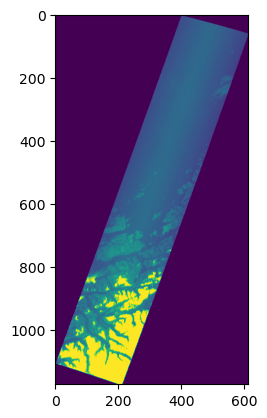

In [81]:
import matplotlib.pyplot as plt
plt.imshow(numpy_array[:,:,40])